In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results/e2e_profs_new_metrics')
print HOME

/Users/EyalPC/Desktop/plots-model-comp-paper/results/e2e_profs_new_metrics


In [18]:
from enum import Enum
import unicodedata
        
def cache_extractions(FN):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["client_metrics"][0]["all_metrics"]
    result = {}
    for i in range(len(all_metrics)):
        data_lists = all_metrics[i]["data_lists"]
        for item in data_lists:
            key = item.keys()[0]
            key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
            if result.get(key) == None:
                result[key] = []
            value = np.asarray(item[key]["items"]).astype(float)
            result[key].append(value)
    for key, value in result.iteritems():
        result[key] = np.concatenate(value)
    return result

image_driver_1_models = [
    "tf-resnet-feats",
    "tf-log-reg",
    "tf-kernel-svm",
    "inception"
]

image_driver_1_500ms_all_1 = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_1-180207_210822.json")

for key, value in image_driver_1_500ms_all_1.iteritems():
    print key, value.shape

app:inception:prediction_latencies (1803,)
app:tf-log-reg:prediction_latencies (1803,)
tf-log-reg:1:queue_sizes (3606,)
inception:processing_latency (1804,)
inception:1:queue_arrivals (1803,)
tf-resnet-feats:processing_latency (1729,)
tf-resnet-feats:1:queue_sizes (3532,)
tf-log-reg:processing_latency (1803,)
app:tf-kernel-svm:prediction_latencies (1803,)
tf-kernel-svm:processing_latency (1803,)
model:tf-resnet-feats:1:prediction_latencies_list (1729,)
tf-resnet-feats:1:queue_arrivals (1804,)
tf-kernel-svm:1:queue_sizes (3606,)
inception:1:queue_sizes (3606,)
model:tf-log-reg:1:prediction_latencies_list (1803,)
model:tf-kernel-svm:1:prediction_latencies_list (1803,)
tf-log-reg:1:queue_arrivals (1803,)
model:inception:1:prediction_latencies_list (1802,)
tf-kernel-svm:1:queue_arrivals (1803,)
app:tf-resnet-feats:prediction_latencies (1803,)


In [58]:
def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency (ms)")
        processing_time = cached_extractions[model+":processing_latency"]
        total_time = cached_extractions["app:"+model+":prediction_latencies"]
        lineHistogram(processing_time, label="Processing time")
        lineHistogram(total_time/1000, label="Processing + Queueing time")
    plt.legend()

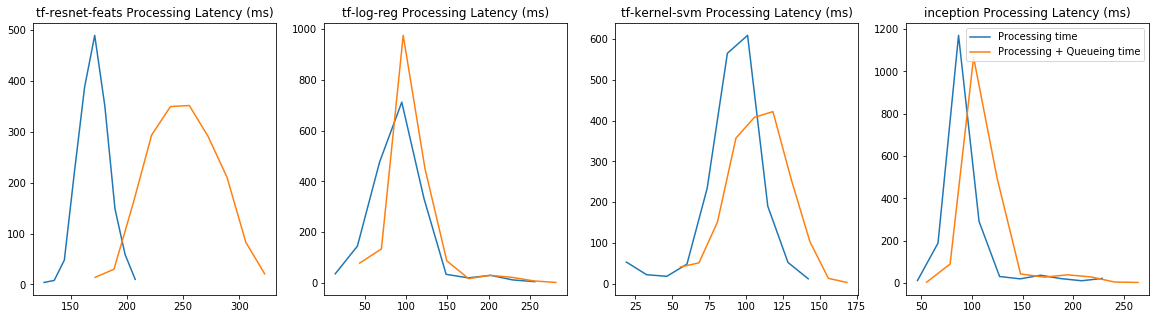

In [59]:
compare_latency_dists(image_driver_1_500ms_all_1, image_driver_1_models)

In [54]:
logreg_arrivals = image_driver_1_500ms["tf-log-reg:1:queue_arrivals"]
svm_arrivals = image_driver_1_500ms["tf-kernel-svm:1:queue_arrivals"]
inception_arrivals = image_driver_1_500ms["inception:1:queue_arrivals"]
resnet_arrivals = image_driver_1_500ms["tf-resnet-feats:1:queue_arrivals"]

logreg_intervals = logreg_arrivals[1:] - logreg_arrivals[:-1]
svm_intervals = svm_arrivals[1:] - svm_arrivals[:-1]
inception_intervals = inception_arrivals[1:] - inception_arrivals[:-1]
resnet_intervals = resnet_arrivals[1:] - resnet_arrivals[:-1]

def plot_inter_arrival(cached_extractions, model_list):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time (ms)")
    for model in model_list:
        arrivals = cached_extractions[model+":1:queue_arrivals"]
        intervals = arrivals[1:] - arrivals[:-1]
        lineHistogram(intervals/1000, label=model)
    plt.legend()

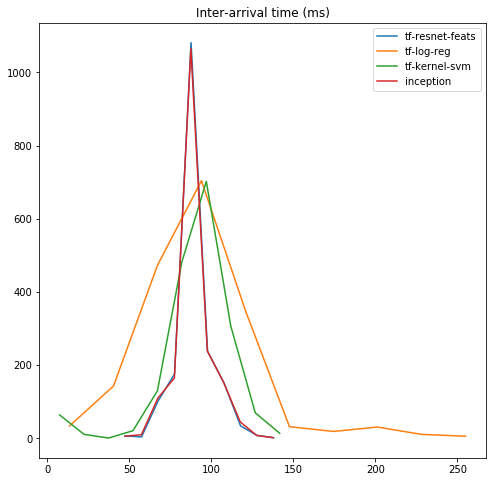

In [55]:
plot_inter_arrival(image_driver_1_500ms_all_1, image_driver_1_models)

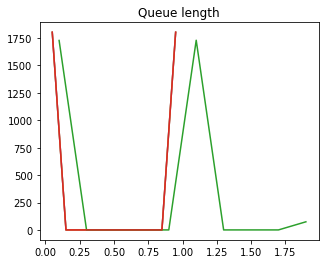

In [16]:
svm_Q_sizes = image_driver_1_500ms["tf-kernel-svm:1:queue_sizes"]
inception_Q_sizes = image_driver_1_500ms["inception:1:queue_sizes"]
resnet_Q_sizes = image_driver_1_500ms["tf-resnet-feats:1:queue_sizes"]
logres_Q_sizes = image_driver_1_500ms["tf-log-reg:1:queue_sizes"]

plt.title("Queue length")
lineHistogram(svm_Q_sizes)
lineHistogram(inception_Q_sizes)
lineHistogram(resnet_Q_sizes)
lineHistogram(logres_Q_sizes)